<a href="https://colab.research.google.com/github/eluyutao/text_classification/blob/main/NLP_Team_Assignment_Deep_ML_Model_UNFROZEN_0_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 891 - TOPIC ANALYSIS 
## Topic Analysis on "Finance" Corpus
The goal of this excercise is to build a topic analyzer using the pretrained DistilBert published by HuggingFace. The dataset is from CodaLab, copied local to Google Drive.



In [1]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly
!pip install keras_tuner

import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

import tensorflow_datasets as tfds
import keras_tuner as kt

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# My additions
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 4.3 MB 61.5 MB/s 
     |████████████████████████████████| 895 kB 72.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 596 kB 52.4 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 133 kB 4.0 MB/s 


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [2]:
# 891 specific additions
!pip install google.colab
# from google.colab import drive
# drive.mount('/content/drive')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# (from Lucas) -- I'd like to measure DistilBERT performance with stop words
# removed from the corpus
!pip install unidecode
from nltk.corpus import stopwords
import nltk
import re
import unidecode
nltk.download('stopwords')

     |████████████████████████████████| 235 kB 4.1 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
pd.set_option("display.max_columns", 200)

In [5]:
# Load training data
url = "https://drive.google.com/file/d/1tGyKaXM5Z3xLCrQy-MeVK-11eAee82Ms/view"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10466 entries, 0 to 10465
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       10466 non-null  int64 
 1   message  10466 non-null  object
 2   label    10466 non-null  object
dtypes: int64(1), object(2)
memory usage: 245.4+ KB
None
     id                                            message  \
0  5396  I made a purchase recently but I have decided ...   
1  2202                        Cancel my transfer, please.   
2  3768                      How do I change my last name?   
3  4967  A withdraw I tried to make at the ATM was decl...   
4  5622  I tried to buy something online yesterday and ...   

                      label  
0            request_refund  
1           cancel_transfer  
2     edit_personal_details  
3  declined_cash_withdrawal  
4         declined_transfer  


# DATA PREPARATION

### Remove stop words (NLTK)

In [6]:
stop_words = set(stopwords.words('english'))

# Considerations; things to add to preprocessing
# 1. All occurrences of '>' are typos for '?', regex sub these
# 2. ATM is sometimes 'ATM' and others 'ATMs', switch all to 'ATM'
# 3. Currency abbreviations could be expanded, e.g. USD, GBP, AUD
# 4. Geographic abbreviations could be expanded, EU, US
# 5. There are a few extremely long messages, remove stop words when tokens are greater than threshold

def preprocess(x):
    x = x.lower()
    #x = re.sub(r'[^\w\s]', '', x)
    x = unidecode.unidecode(x)
    x = re.sub(r'\d+', '', x)
    # 1. Correct typo
    x = re.sub('>', '?', x)
    # 5. Shorten sentences > 60
    if len(x.split()) > 60:
      x = [w for w in x.split() if w not in stop_words]
      x = ' '.join(x)
    return x#' '.join(x)

df['message_clean'] = df['message'].apply(preprocess)
df.message_clean.iloc[403]

'is the bank the only place i can change my pin?'

In [7]:
print(df.shape)
df.head(2)

(10466, 4)


,id,message,label,message_clean
0,5396,I made a purchase recently but I have decided ...,request_refund,i made a purchase recently but i have decided ...
1,2202,"Cancel my transfer, please.",cancel_transfer,"cancel my transfer, please."


# Train/Validation SPLIT, PIPELINE 

In [8]:
# Data / Label split
#X = df['message_clean'].str.lower()

# used to be 'message', but running on preprocessed data now
# don't need to force to lower b/c that will be done through pipeline
clean=True

if clean:
  X = df['message_clean']
else:
  X = df['message'].str.lower()
y = df['label']

# ONE HOT ENCODE FOR TRANSFORMER (before train/test split)

In [9]:
# From this website:
# https://towardsdatascience.com/how-to-assign-labels-with-sklearn-one-hot-encoder-e59a5f17df4f

from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{self.categories_[i][j]}')
                j += 1
        return new_columns

In [10]:
def ohe (labels):
  encoder = OneHotEncoder(handle_unknown='ignore')

  df = pd.DataFrame(labels)
  encoder_df = pd.DataFrame(encoder.fit_transform(df))

  return encoder_df

In [11]:
y = ohe(y)

In [12]:
y.head()

,Refund_not_showing_up,activate_my_card,age_limit,apple_pay_or_google_pay,atm_support,automatic_top_up,balance_not_updated_after_bank_transfer,balance_not_updated_after_cheque_or_cash_deposit,beneficiary_not_allowed,cancel_transfer,card_about_to_expire,card_acceptance,card_arrival,card_delivery_estimate,card_linking,card_not_working,card_payment_fee_charged,card_payment_not_recognised,card_payment_wrong_exchange_rate,card_swallowed,cash_withdrawal_charge,cash_withdrawal_not_recognised,change_pin,compromised_card,contactless_not_working,country_support,declined_card_payment,declined_cash_withdrawal,declined_transfer,direct_debit_payment_not_recognised,disposable_card_limits,edit_personal_details,exchange_charge,exchange_rate,exchange_via_app,extra_charge_on_statement,failed_transfer,fiat_currency_support,get_disposable_virtual_card,get_physical_card,getting_spare_card,getting_virtual_card,lost_or_stolen_card,lost_or_stolen_phone,order_physical_card,passcode_forgotten,pending_card_payment,pending_cash_withdrawal,pending_top_up,pending_transfer,pin_blocked,receiving_money,request_refund,reverted_card_payment?,supported_cards_and_currencies,terminate_account,top_up_by_bank_transfer_charge,top_up_by_card_charge,top_up_by_cash_or_cheque,top_up_failed,top_up_limits,top_up_reverted,topping_up_by_card,transaction_charged_twice,transfer_fee_charged,transfer_into_account,transfer_not_received_by_recipient,transfer_timing,unable_to_verify_identity,verify_my_identity,verify_source_of_funds,verify_top_up,virtual_card_not_working,visa_or_mastercard,why_verify_identity,wrong_amount_of_cash_received,wrong_exchange_rate_for_cash_withdrawal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# want to save off 1/2 the validation data for prediction inference
X_val, X_val2, y_val, y_val2 = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_val2.shape)
print(y_val2.shape)

(7326,)
(7326, 77)
(1570,)
(1570, 77)
(1570,)
(1570, 77)


In [14]:
#vectorizer = CountVectorizer(min_df=.01, max_df=.8, ngram_range=[1,1], max_features=300, stop_words='english')
#
#pipe = Pipeline([('vec', vectorizer),  ('clf', DecisionTreeClassifier(random_state=223))])
#
#pipe.fit(X_train, y_train)

In [15]:
#from sklearn.metrics import confusion_matrix, classification_report
#
#pred_val = pipe.predict(X_val)
#print(confusion_matrix(y_val, pred_val))
#print(classification_report(y_val, pred_val))

In [16]:
#from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
#
#ari = adjusted_rand_score(y_val, pred_val)
#ami = adjusted_mutual_info_score(y_val, pred_val, average_method='arithmetic')
#
#print("ARI: {}".format(ari))
#print("AMI: {}".format(ami))

# TEST DATA LOAD, PIPELINE and SUBMISSION

In [17]:
# Load test data
url = "https://drive.google.com/file/d/1tLyDoULJRiSimJLkmFAw1i9RnOR-eElY/view"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_test = pd.read_csv(path)
df_test.info()

if clean:
  df_test['message_clean'] = df_test['message'].apply(preprocess)
else:
  df_test['message'] = df_test['message'].str.lower()    # OLD
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2617 non-null   int64 
 1   message  2617 non-null   object
dtypes: int64(1), object(1)
memory usage: 41.0+ KB


,id,message,message_clean
0,5037,The ATM cancelled a transaction on me when I w...,the atm cancelled a transaction on me when i w...
1,3461,where is my money from this morning,where is my money from this morning
2,995,I would like to know which fiat currencies are...,i would like to know which fiat currencies are...
3,2890,Why did I get a fee?,why did i get a fee?
4,9274,I need my card to be activated right now.,i need my card to be activated right now.


In [18]:
# Run the pipeline
#pred_test = pipe.predict(df_test['message'])

In [19]:
# Package predictions as dataframe
#my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
#print(my_submission.head())

In [20]:
# NOTE: after saving the CSV file, be sure to zip the file before submitting to the competition website!
#my_submission.to_csv('answers.csv', index=False)

# TRANSFORMER STUFF

In [21]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
#print(f'X_val2 shape: {X_val2.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
#print(f'y_val2 shape: {y_val2.shape}')

X_train shape: (7326,)
X_val shape: (1570,)
y_train shape: (7326, 77)
y_val shape: (1570, 77)


In [22]:
# XXX Come back later and go from Series to list. Skip the dataframe step
df_X_train = X_train.to_frame()
df_X_val   = X_val.to_frame()
df_X_val2  = X_val2.to_frame()

#print(f'y_train, y_val and y_val2 are already DataFrames:\n{type(y_train), type(y_val), type(y_val2)}')
#df_y_train = y_train.to_frame()
#df_y_val   = y_val.to_frame()
#df_y_val2  = y_val2.to_frame()
df_y_train = y_train
df_y_val   = y_val
df_y_val2  = y_val2


In [23]:
df_y_train.head(2)

,Refund_not_showing_up,activate_my_card,age_limit,apple_pay_or_google_pay,atm_support,automatic_top_up,balance_not_updated_after_bank_transfer,balance_not_updated_after_cheque_or_cash_deposit,beneficiary_not_allowed,cancel_transfer,card_about_to_expire,card_acceptance,card_arrival,card_delivery_estimate,card_linking,card_not_working,card_payment_fee_charged,card_payment_not_recognised,card_payment_wrong_exchange_rate,card_swallowed,cash_withdrawal_charge,cash_withdrawal_not_recognised,change_pin,compromised_card,contactless_not_working,country_support,declined_card_payment,declined_cash_withdrawal,declined_transfer,direct_debit_payment_not_recognised,disposable_card_limits,edit_personal_details,exchange_charge,exchange_rate,exchange_via_app,extra_charge_on_statement,failed_transfer,fiat_currency_support,get_disposable_virtual_card,get_physical_card,getting_spare_card,getting_virtual_card,lost_or_stolen_card,lost_or_stolen_phone,order_physical_card,passcode_forgotten,pending_card_payment,pending_cash_withdrawal,pending_top_up,pending_transfer,pin_blocked,receiving_money,request_refund,reverted_card_payment?,supported_cards_and_currencies,terminate_account,top_up_by_bank_transfer_charge,top_up_by_card_charge,top_up_by_cash_or_cheque,top_up_failed,top_up_limits,top_up_reverted,topping_up_by_card,transaction_charged_twice,transfer_fee_charged,transfer_into_account,transfer_not_received_by_recipient,transfer_timing,unable_to_verify_identity,verify_my_identity,verify_source_of_funds,verify_top_up,virtual_card_not_working,visa_or_mastercard,why_verify_identity,wrong_amount_of_cash_received,wrong_exchange_rate_for_cash_withdrawal
3635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print(clean)

True


Next, we need to prepare the text for DistilBert. Instead of ingesting raw text, the model uses token IDs to map to internal embedding. Additionally, since the input is fixed size (due to our use of batches), we need to let the model know which tokens to use (i.e. are part of the sentence).

Luckily, `dbert_tokenizer` takes care of all that for us - 
- Preprocessing: https://huggingface.co/transformers/preprocessing.html
- Summary of tokenizers (DistilBert uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece

In [25]:
def make_y_a_numpy_array(df):
  # Initially thoughts I needed lists, but this is simple df to numpy
  y = df.to_numpy()
  return y


def encode_text(text):
    # TODO: encode text using dbert_tokenizer
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    batch_size = 128
    input_ids = []
    attention_mask = []

    # Use preprocessed data
    if clean:
      temp = text['message_clean'].to_list()
    else:
      temp = text['message'].to_list()#   <-- OLD

    for count in range(0, len(text), batch_size):
      batch_text = temp[count:count+batch_size]
      # have to truncate b/c was resulting in a non-rectangular shape
      output = dbert_tokenizer(batch_text,
                             padding='max_length',
                             return_attention_mask=True,
                             # REDUCED from 256 -> 128 to avoid GPU overload 07Apr22
                             max_length=160, #128, #256, #96  # was 512, but took waay too long
                             truncation=True
                             )
      input_ids.extend(output['input_ids'])
      attention_mask.extend(output['attention_mask'])

    # Try switching everything to numpy arrays
    input_ids = np.array(input_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, attention_mask

# the following prepares the input for running in DistilBert
np_array_y_train = make_y_a_numpy_array(df_y_train)
np_array_y_val   = make_y_a_numpy_array(df_y_val)
np_array_y_val2  = make_y_a_numpy_array(df_y_val2)

train_input, train_mask = encode_text(df_X_train)
val_input, val_mask = encode_text(df_X_val)
val_input2, val_mask2 = encode_text(df_X_val2)
test_input, test_mask = encode_text(df_test)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

val_model_inputs_and_masks2 = {
    'inputs' : val_input2,
    'masks' : val_mask2
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

In [188]:
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
sbert_emb = SentenceTransformer('all-mpnet-base-v2')
#Sentences are encoded by calling model.encode()
# embeddings = sbert_emb.encode(sentences)
# import tensorflow_hub as hub
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# use_model = hub.load(module_url)
def embed(input):
    # return use_model(input)
    return sbert_emb.encode(input)

In [190]:
%%time
sembed_all = embed(df.message)
# .numpy()
print(sembed_all.shape)
# sembed_all = pd.DataFrame(sembed_all)
# sembed_all.head(2)

(10466, 768)
CPU times: user 14.5 s, sys: 107 ms, total: 14.6 s
Wall time: 13.9 s


In [191]:
%%time
sembed_all_t = embed(df_test.message)
# .numpy()
print(sembed_all_t.shape)
# sembed_all_t = pd.DataFrame(sembed_all_t)
# sembed_all_t.head(2)

(2617, 768)
CPU times: user 3.74 s, sys: 12.3 ms, total: 3.75 s
Wall time: 3.58 s


In [192]:
type(sembed_all)

numpy.ndarray

In [216]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [233]:
stop_words = set(stopwords.words('english'))
lemmer = WordNetLemmatizer()
def preprocess(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = unidecode.unidecode(x)
    x = re.sub(r'\d+', '', x)
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    return ' '.join(x)
df['message_clean_more'] = df['message'].apply(preprocess)
df_test['message_clean_more'] = df_test['message'].apply(preprocess)

In [251]:
vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.01, max_features = 500, ngram_range=[1,3])
dtm = vectorizer.fit_transform(df['message_clean_more'])
print(dtm.shape)
bow_df = pd.DataFrame(dtm.toarray(), columns=[f'{x}_f' for x in vectorizer.get_feature_names()], index=df.index)
bow_df = pd.concat([df, bow_df], axis=1)
print(bow_df.shape)
bow_df.head(2)
bow_df_t = pd.DataFrame(vectorizer.transform(df_test.message_clean_more).toarray(),
                      columns=[f'{x}_f' for x in vectorizer.get_feature_names_out()], index=df_test.index)


(10466, 125)
(10466, 130)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [252]:
sembed_df = df.join(pd.DataFrame(sembed_all))
sembed_df_t = df_test.join(pd.DataFrame(sembed_all_t))

In [253]:
sembed_df_t.head(2)

,id,message,message_clean,message_clean_more,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,5037,The ATM cancelled a transaction on me when I w...,the atm cancelled a transaction on me when i w...,atm cancelled transaction trying get cash,-0.025365,-0.081200,0.011201,0.01755,0.030067,0.042854,0.003690,-0.017269,-0.053591,0.026023,0.013522,0.016009,0.005019,-0.004818,-0.011349,0.093806,-0.024846,-0.046280,0.015105,-0.000358,-0.031073,0.062567,0.014586,0.03674,-0.008589,0.041260,0.030605,-0.005761,0.031805,-0.006183,0.019638,-0.072471,-0.006727,-0.017517,0.000002,-0.040840,0.012695,0.023567,-0.101512,0.034254,-0.039548,0.031519,0.0063,0.010906,0.017815,0.014784,0.030103,0.052343,0.021922,-0.010274,-0.023201,0.017850,-0.031509,0.020635,-0.058501,-0.046805,-0.009990,0.004213,-0.001127,-0.048213,0.028326,0.010301,0.005106,-0.003122,-0.064158,-0.004731,-0.054970,-0.020900,0.040036,0.065455,-0.059367,0.020790,-0.014585,-0.009529,-0.002415,-0.021980,-0.036754,0.011690,0.010207,0.047017,-0.030053,0.041617,0.042064,0.010312,-0.009734,-0.083631,0.036097,-0.005475,-0.003305,0.036631,-0.052073,0.059118,-0.012143,-0.043539,-0.014926,-0.008043,...,-0.001307,0.098468,-0.005895,0.015538,0.002603,-0.098062,-0.031877,0.058531,-0.016082,-0.068975,-0.010473,0.071724,0.002261,0.032092,0.01903,0.017558,0.010546,0.046847,-0.011696,-0.009634,2.343639e-07,-0.010964,0.006683,0.030143,-0.063159,-0.023293,0.018157,-0.013412,0.006584,0.069429,0.041660,0.016254,0.040333,0.009487,-0.083840,-0.045620,-0.032989,0.060579,0.078757,0.043493,-0.019262,0.032375,0.016549,0.017912,-0.050828,0.054520,0.023073,-0.004746,-0.034018,-0.063709,-0.052491,0.011578,0.020150,0.029868,-0.007369,0.009442,-0.013191,-0.010617,-0.001854,0.026787,-0.021720,-0.030939,-0.008175,0.038336,-0.007954,-0.020680,-0.034384,-0.004499,0.033839,-0.036192,0.013105,-0.035318,0.007479,-0.028348,0.024548,0.005349,0.000911,0.007152,0.024216,0.029647,0.058426,0.025474,0.026417,0.009577,-0.015486,-0.080978,0.022089,-0.025220,1.073748e-34,0.016541,0.003159,0.021263,0.023472,0.007088,-0.044980,0.031933,-0.002192,-0.026748,0.035193,0.014792
1,3461,where is my money from this morning,where is my money from this morning,money morning,0.004571,0.027316,0.003719,0.05064,-0.006585,-0.000291,-0.005189,-0.027210,-0.020834,0.031220,0.004571,0.018122,-0.009509,-0.005511,0.067447,-0.002857,0.033609,-0.032585,0.014059,0.000491,0.032045,0.014761,0.033206,0.04399,-0.019473,0.016275,0.003388,0.020190,0.036881,0.008319,0.005484,-0.036250,-0.017312,-0.000184,0.000002,-0.048271,-0.000827,0.033344,-0.088504,0.014116,-0.034111,0.014051,0.0226,0.010002,0.037001,0.022440,-0.016167,0.022683,-0.043349,0.040601,-0.005180,-0.016052,-0.070652,-0.009944,0.030206,-0.025740,0.040091,0.018964,-0.059904,-0.058551,0.062180,-0.044049,-0.026216,-0.001468,0.030341,0.028440,-0.013427,0.030844,-0.030365,-0.048636,0.001740,0.037979,0.018351,0.043026,-0.014835,-0.027962,-0.024899,0.070187,0.008673,0.008051,-0.010896,0.010182,0.019880,0.078442,-0.045406,0.004297,-0.005283,0.021659,0.009324,0.050169,-0.009565,0.029382,0.000151,-0.027632,0.059148,0.008273,...,-0.020330,0.059639,0.009466,0.044196,-0.015753,-0.023896,-0.032766,0.054648,0.025771,0.021221,-0.041577,0.049256,0.017659,-0.005234,-0.05380,0.030643,0.010818,0.053750,-0.022463,-0.044137,2.461926e-07,0.021444,-0.005952,0.037496,-0.006710,-0.015200,0.009981,-0.01639

In [254]:
sembed_train = pd.merge(sembed_df.iloc[:,5:], df_X_train, how='inner', left_index=True, right_index=True).drop(labels=['message_clean'], axis=1)
sembed_val = pd.merge(sembed_df.iloc[:,5:], df_X_val, how='inner', left_index=True, right_index=True).drop(labels=['message_clean'], axis=1)
sembed_test = pd.merge(sembed_df_t.iloc[:,4:], df_test, how='inner', left_index=True, right_index=True).drop(labels=['message_clean', 'message', 'id', 'message_clean_more'], axis=1)
print(sembed_train.shape)
print(sembed_val.shape)
print(sembed_test.shape)

(7326, 768)
(1570, 768)
(2617, 768)


In [255]:
sembed_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.025365,-0.081200,0.011201,0.01755,0.030067,0.042854,0.003690,-0.017269,-0.053591,0.026023,0.013522,0.016009,0.005019,-0.004818,-0.011349,0.093806,-0.024846,-0.046280,0.015105,-0.000358,-0.031073,0.062567,0.014586,0.03674,-0.008589,0.041260,0.030605,-0.005761,0.031805,-0.006183,0.019638,-0.072471,-0.006727,-0.017517,0.000002,-0.040840,0.012695,0.023567,-0.101512,0.034254,-0.039548,0.031519,0.0063,0.010906,0.017815,0.014784,0.030103,0.052343,0.021922,-0.010274,-0.023201,0.017850,-0.031509,0.020635,-0.058501,-0.046805,-0.009990,0.004213,-0.001127,-0.048213,0.028326,0.010301,0.005106,-0.003122,-0.064158,-0.004731,-0.054970,-0.020900,0.040036,0.065455,-0.059367,0.020790,-0.014585,-0.009529,-0.002415,-0.021980,-0.036754,0.011690,0.010207,0.047017,-0.030053,0.041617,0.042064,0.010312,-0.009734,-0.083631,0.036097,-0.005475,-0.003305,0.036631,-0.052073,0.059118,-0.012143,-0.043539,-0.014926,-0.008043,0.030705,0.058924,-0.004749,-0.027045,...,-0.001307,0.098468,-0.005895,0.015538,0.002603,-0.098062,-0.031877,0.058531,-0.016082,-0.068975,-0.010473,0.071724,0.002261,0.032092,0.01903,0.017558,0.010546,0.046847,-0.011696,-0.009634,2.343639e-07,-0.010964,0.006683,0.030143,-0.063159,-0.023293,0.018157,-0.013412,0.006584,0.069429,0.041660,0.016254,0.040333,0.009487,-0.083840,-0.045620,-0.032989,0.060579,0.078757,0.043493,-0.019262,0.032375,0.016549,0.017912,-0.050828,0.054520,0.023073,-0.004746,-0.034018,-0.063709,-0.052491,0.011578,0.020150,0.029868,-0.007369,0.009442,-0.013191,-0.010617,-0.001854,0.026787,-0.021720,-0.030939,-0.008175,0.038336,-0.007954,-0.020680,-0.034384,-0.004499,0.033839,-0.036192,0.013105,-0.035318,0.007479,-0.028348,0.024548,0.005349,0.000911,0.007152,0.024216,0.029647,0.058426,0.025474,0.026417,0.009577,-0.015486,-0.080978,0.022089,-0.025220,1.073748e-34,0.016541,0.003159,0.021263,0.023472,0.007088,-0.044980,0.031933,-0.002192,-0.026748,0.035193,0.014792
1,0.004571,0.027316,0.003719,0.05064,-0.006585,-0.000291,-0.005189,-0.027210,-0.020834,0.031220,0.004571,0.018122,-0.009509,-0.005511,0.067447,-0.002857,0.033609,-0.032585,0.014059,0.000491,0.032045,0.014761,0.033206,0.04399,-0.019473,0.016275,0.003388,0.020190,0.036881,0.008319,0.005484,-0.036250,-0.017312,-0.000184,0.000002,-0.048271,-0.000827,0.033344,-0.088504,0.014116,-0.034111,0.014051,0.0226,0.010002,0.037001,0.022440,-0.016167,0.022683,-0.043349,0.040601,-0.005180,-0.016052,-0.070652,-0.009944,0.030206,-0.025740,0.040091,0.018964,-0.059904,-0.058551,0.062180,-0.044049,-0.026216,-0.001468,0.030341,0.028440,-0.013427,0.030844,-0.030365,-0.048636,0.001740,0.037979,0.018351,0.043026,-0.014835,-0.027962,-0.024899,0.070187,0.008673,0.008051,-0.010896,0.010182,0.019880,0.078442,-0.045406,0.004297,-0.005283,0.021659,0.009324,0.050169,-0.009565,0.029382,0.000151,-0.027632,0.059148,0.008273,0.032795,0.042892,0.004011,-0.042639,...,-0.020330,0.059639,0.009466,0.044196,-0.015753,-0.023896,-0.032766,0.054648,0.025771,0.021221,-0.041577,0.049256,0.017659,-0.005234,-0.05380,0.030643,0.010818,0.053750,-0.022463,-0.044137,2.461926e-07,0.021444,-0.005952,0.037496,-0.006710,-0.015200,0.009981,-0.016390,-0.011255,-0.005653,-0.010701,0.021095,0.023918,0.000345,-0.051252,0.014467,-0.073357,0.035486,-0.006125,-0.038047,-0.020209,-0.026290,0.025119,0.029254,0.001478,0.028654,-0.033479,-0.015969,-0

In [256]:
sembed_train = np.array(sembed_train.merge(bow_df.iloc[:,5:], how='inner', left_index=True, right_index=True))
sembed_val = np.array(sembed_val.merge(bow_df.iloc[:,5:], how='inner', left_index=True, right_index=True))
sembed_test = np.array(sembed_test.merge(bow_df.iloc[:,5:], how='inner', left_index=True, right_index=True))
print(sembed_train.shape)
print(sembed_val.shape)
print(sembed_test.shape)

(7326, 893)
(1570, 893)
(2617, 893)


# Modelling

## Build and Train Model

Resources:
- BERT paper https://arxiv.org/pdf/1810.04805.pdf
- DistilBert paper: https://arxiv.org/abs/1910.01108
- DistilBert Tensorflow Documentation: https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

In [26]:
!pip install swish
import swish

     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for swish: filename=swish-1.1-py3-none-any.whl size=14622 sha256=a52c24600dfaa49643340270c86d1626bd8135677e52f445390e33d02e25ee91
  Stored in directory: /root/.cache/pip/wheels/68/e1/ec/15b75e6337ed7428e0b9e0d61acebef8431bd7b485614dde43
Successfully built swish


In [257]:
def build_model(base_model, trainable=False, params={}):
    # TODO: build the model, with the option to freeze the parameters in distilBERT
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # Hint 1: the cls token (token for classification in bert / distilBert) corresponds to the first element in the sequence in DistilBert. Take a look at Figure 2 in BERT paper.
    # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
    # Hint 3: double check that your number of parameters make sense
    # Hint 4: carefully consider your final layer activation and loss function

    # Refer to https://keras.io/api/layers/core_layers/input/
    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)

    inputs = Input(shape=(max_seq_len,), 
                   name='input_ids', 
                   dtype='int32')
    masks  = Input(shape=(max_seq_len,), 
                   name='input_attention', 
                   dtype='int32')
    sbert_input = keras.Input(
        shape=(sembed_train.shape[1],), name="Sentense Encoding", dtype='float32'
    )  # vectors of size `768`


    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)
    # dbert_last_hidden_state gets you the output encoding for each of your tokens.
    # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
    # which can be used to build a sentence classification network
    dbert_last_hidden_state = dbert_output.last_hidden_state


    # Any additional layers should go here
    # use the 'params' as a dictionary for hyper parameter to facilitate experimentation
    cls_token = dbert_last_hidden_state[:, 0, :]

    combine = tf.keras.layers.concatenate([cls_token, sbert_input])
    X = tf.keras.layers.BatchNormalization()(combine)
    X = tf.keras.layers.Dense(128, activation='swish')(X) 

    

    print('X', type(X))
    
    # X = tf.keras.layers.Dropout(layer_dropout)(X)

    my_output = X
    probs = Dense(77, #23, #28, 
                  #activation='softmax',
                  activation='sigmoid',
                  kernel_initializer=initial_weights,  
                  kernel_constraint=None,
                  bias_initializer='zeros'
                  )(my_output)

    model = keras.Model(inputs=[inputs, masks, sbert_input], outputs=probs)
    model.summary()
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
params= {
        # MAX_SEQ_LEN: 256 -> 128 to avoid GPU RAM exhaustion - 07Apr22
        "max_seq_len":160, #128, #256,
        "layer_dropout":0.25,
        "learning":1e-4,#1e-4, #5e-4,#0.001,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


X <class 'keras.engine.keras_tensor.KerasTensor'>
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 160)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 160)]        0           []                               
                                                                                                  
 tf_distil_bert_model_24 (TFDis  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 tilBertModel)                  ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 160, 768),                                                   
                                 hidden_s

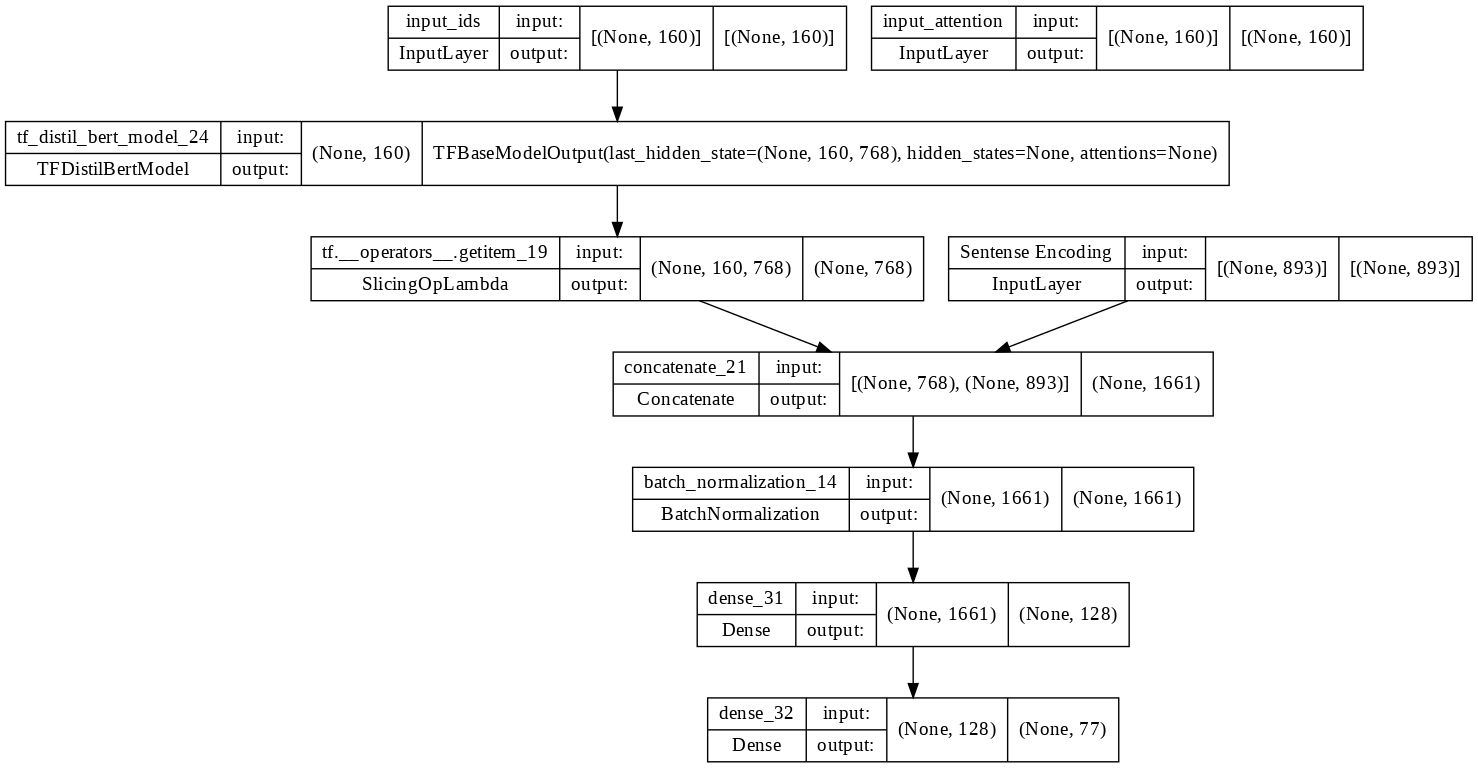

In [258]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [259]:
from sklearn.metrics import roc_auc_score

def compile_model(model):
    # TODO: compile the model, include relevant auc metrics when training
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    # Metrics
    metrics = [keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.CategoricalAccuracy(), keras.metrics.AUC()]#,
               #keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32),
               #keras.metrics.Precision()]#, label_smoothing=0.5)]

    # Switch to Categorical to support multi-class classification
    loss = keras.losses.CategoricalCrossentropy()
    # Try binary cross-entropy and switch model to sigmoid
    #loss = keras.losses.BinaryCrossentropy()
    # Use a new one from TFA
    #loss = tfa.losses.SigmoidFocalCrossEntropy()

    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), 
                  loss=loss,
                  metrics=metrics)

    return model

model = compile_model(model)

In [260]:
#DEBUG - check shapes
print(train_model_inputs_and_masks["inputs"].shape,
train_model_inputs_and_masks["masks"].shape,
val_model_inputs_and_masks["inputs"].shape,
val_model_inputs_and_masks["masks"].shape, 
#val_model_inputs_and_masks2["inputs"].shape,
#val_model_inputs_and_masks2["masks"].shape, 
'\n',
sembed_train.shape,
sembed_val.shape,
sembed_test.shape,
np_array_y_train.shape,
#np_array_y_val2.shape,
np_array_y_val.shape)

(7326, 160) (7326, 160) (1570, 160) (1570, 160) 
 (7326, 893) (1570, 893) (2617, 893) (7326, 77) (1570, 77)


In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val, sembed_train, sembed_val,
    y_train, y_val, batch_size, num_epochs):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    reduce_lr  = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

    history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
                        model_inputs_and_masks_train["masks"],
                        sembed_train],
                        y = y_train,
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=([model_inputs_and_masks_val["inputs"],
                                          model_inputs_and_masks_val["masks"],
                                          sembed_val],
                                         y_val),
                        verbose=2,
                        callbacks=[reduce_lr])#,
                        #class_weight=class_weights)

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, sembed_train, sembed_val, np_array_y_train, np_array_y_val, batch_size=48, num_epochs=15)

Epoch 1/15
153/153 - 120s - loss: 1.5067 - Cat-CE: 1.5067 - categorical_accuracy: 0.6589 - auc_6: 0.9431 - val_loss: 0.5874 - val_Cat-CE: 0.5874 - val_categorical_accuracy: 0.8713 - val_auc_6: 0.9902 - lr: 1.0000e-04 - 120s/epoch - 787ms/step
Epoch 2/15
153/153 - 118s - loss: 0.3076 - Cat-CE: 0.3076 - categorical_accuracy: 0.9255 - auc_6: 0.9958 - val_loss: 0.3921 - val_Cat-CE: 0.3921 - val_categorical_accuracy: 0.8955 - val_auc_6: 0.9911 - lr: 1.0000e-04 - 118s/epoch - 774ms/step
Epoch 3/15
153/153 - 118s - loss: 0.1319 - Cat-CE: 0.1319 - categorical_accuracy: 0.9694 - auc_6: 0.9974 - val_loss: 0.3724 - val_Cat-CE: 0.3724 - val_categorical_accuracy: 0.9134 - val_auc_6: 0.9906 - lr: 1.0000e-04 - 118s/epoch - 774ms/step
Epoch 4/15
153/153 - 118s - loss: 0.0735 - Cat-CE: 0.0735 - categorical_accuracy: 0.9824 - auc_6: 0.9977 - val_loss: 0.4160 - val_Cat-CE: 0.4160 - val_categorical_accuracy: 0.9064 - val_auc_6: 0.9891 - lr: 1.0000e-04 - 118s/epoch - 773ms/step
Epoch 5/15
153/153 - 118s - 

In [ ]:
# def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
#     y_train, y_val, batch_size, num_epochs):
#     # TODO: train the model
#     # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

#     reduce_lr  = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)

#     history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
#                         train_model_inputs_and_masks["masks"]],
#                         y = y_train,
#                         batch_size=batch_size, epochs=num_epochs, 
#                         validation_data=([model_inputs_and_masks_val["inputs"],
#                                           model_inputs_and_masks_val["masks"]],
#                                          y_val),
#                         verbose=2,
#                         callbacks=[reduce_lr])#,
#                         #class_weight=class_weights)

#     return model, history

# model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, np_array_y_train, np_array_y_val, batch_size=48, num_epochs=3)

Epoch 1/3
153/153 - 84s - loss: 1.8841 - Cat-CE: 1.8841 - categorical_accuracy: 0.5640 - auc: 0.9110 - val_loss: 0.7831 - val_Cat-CE: 0.7831 - val_categorical_accuracy: 0.8567 - val_auc: 0.9862 - lr: 1.0000e-04 - 84s/epoch - 546ms/step
Epoch 2/3
153/153 - 72s - loss: 0.4957 - Cat-CE: 0.4957 - categorical_accuracy: 0.8803 - auc: 0.9906 - val_loss: 0.4025 - val_Cat-CE: 0.4025 - val_categorical_accuracy: 0.8955 - val_auc: 0.9909 - lr: 1.0000e-04 - 72s/epoch - 470ms/step
Epoch 3/3
153/153 - 72s - loss: 0.2176 - Cat-CE: 0.2176 - categorical_accuracy: 0.9462 - auc: 0.9951 - val_loss: 0.4335 - val_Cat-CE: 0.4335 - val_categorical_accuracy: 0.8962 - val_auc: 0.9896 - lr: 1.0000e-04 - 72s/epoch - 470ms/step


In [125]:
sembed_test

array([[-0.02536482, -0.08119985,  0.01120111, ..., -0.02674792,
         0.03519311,  0.01479239],
       [ 0.0045714 ,  0.02731619,  0.00371898, ...,  0.01846429,
         0.01454927,  0.0009205 ],
       [-0.00682074,  0.01179297, -0.0269319 , ..., -0.01784339,
         0.00359282,  0.04919744],
       ...,
       [ 0.02555272,  0.00408374, -0.00979308, ...,  0.04549129,
        -0.00943796,  0.05662476],
       [ 0.03154739, -0.03402812,  0.01109612, ...,  0.00208085,
        -0.01509698, -0.00368913],
       [ 0.01164143,  0.00155426, -0.00778047, ...,  0.00416513,
        -0.01161584,  0.0297343 ]], dtype=float32)

In [128]:
#test_df = pd.DataFrame()
labels = []
predicts = []
pred_argmax = []
iteration = []

def eval_model(model, inputs_and_masks, s_input, label):
    test_df = pd.DataFrame()
    labels.clear()
    predicts.clear()
    pred_argmax.clear()
    iteration.clear()
    test_scores = model.evaluate(x = [inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"],
                        s_input],
                        y = label, verbose=2)
    test_loss = test_scores[0]
    test_metrics = test_scores[1]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_metrics)
    
    predictions = model.predict([inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"],
                        s_input])
    # GOOD print("past predict call")
    #print(f"Length of [predictions] : {len(predictions)}")
    #print(f"Length of [labels] : {len(labels)}")
    #print(f"Length of [label] : {len(label)}")
    for i in range(len(predictions)):
      labels.append(label[i])
      b = np.zeros_like(predictions[i])
      b[predictions.argmax(1)[i]] = 1
      predicts.append(predictions[i])
      pred_argmax.append(b)
      iteration.append(i)
    
    test_df['Labels'] = labels
    test_df['Predictions'] = predicts
    test_df['Pred-Argmax'] = pred_argmax
    test_df['Iteration'] = iteration
    return test_loss, test_metrics, test_df

val2_df = pd.DataFrame()

test_loss, test_metrics, val2_df = eval_model(model, val_model_inputs_and_masks2, sembed_val, np_array_y_val2)
test_loss, test_metrics, test2_df = eval_model(model, test_model_inputs_and_masks, sembed_test, np.zeros((df_test.shape[0],77), dtype=int))

50/50 - 9s - loss: 0.4686 - Cat-CE: 0.4686 - categorical_accuracy: 0.8892 - auc_1: 0.9908 - 9s/epoch - 174ms/step
Test loss: 0.46856623888015747
Test accuracy: 0.46856623888015747
82/82 - 16s - loss: 0.0000e+00 - Cat-CE: 0.0000e+00 - categorical_accuracy: 0.0145 - auc_1: 0.0000e+00 - 16s/epoch - 200ms/step
Test loss: 0.0
Test accuracy: 0.0


In [129]:
val2_df['Index'] = val2_df['Pred-Argmax'].apply(lambda x: np.argmax(x))
val2_df['Correct-Index'] = val2_df['Labels'].apply(lambda x: np.argmax(x))
val2_df.head(2)

,Labels,Predictions,Pred-Argmax,Iteration,Index,Correct-Index
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6747384, 0.9110714, 0.2657817, 0.43255866, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,13,13
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.42340335, 0.30567378, 0.07086788, 0.4046991...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,50,50


In [130]:
val2_df['Index'].nunique()

77

In [131]:
import re

new_labels = y.columns.values.tolist()
new_labels2 = []
label_list = []
correct_list = []
correct = []

for j in range(val2_df.shape[0]):
  label_list.append(new_labels[val2_df['Index'][j]])
  correct_list.append(new_labels[val2_df['Correct-Index'][j]])
  correct.append((val2_df['Labels'][j] == val2_df['Pred-Argmax'][j]).all())

val2_df['Labels2'] = label_list
val2_df['Correct'] = correct_list
val2_df['True-False'] = correct
val2_df['txt'] = X_val2.values

# incorrect = val2_df#[val2_df['Correct'] == False]
# incorrect.to_csv('incorrect.csv', index=False)
# !cp incorrect.csv "/content/drive/My Drive/"

val2_df.head(10)

,Labels,Predictions,Pred-Argmax,Iteration,Index,Correct-Index,Labels2,Correct,True-False,txt
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6747384, 0.9110714, 0.2657817, 0.43255866, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,13,13,card_delivery_estimate,card_delivery_estimate,True,i need my card asap!
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.42340335, 0.30567378, 0.07086788, 0.4046991...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,50,50,pin_blocked,pin_blocked,True,i put the wrong pin too many times and now it ...
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.91871613, 0.32205433, 0.048690885, 0.260207...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,49,49,pending_transfer,pending_transfer,True,how long do eu transfers take? i bought someth...
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0034700062, 0.93112797, 0.4875668, 0.723264...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,44,24,order_physical_card,contactless_not_working,False,how can i get new card?
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.62245286, 0.12656398, 0.5279662, 0.6941046,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,27,27,declined_cash_withdrawal,declined_cash_withdrawal,True,why was i blocked from withdrawing from the atm?
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8888675, 0.2977953, 0.86738163, 0.31838658,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,28,28,declined_transfer,declined_transfer,True,why did my transfer get declined?
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.019972786, 0.6358679, 0.76290053, 0.5893064...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,10,10,card_about_to_expire,card_about_to_expire,True,when my card expires what happens to my account?
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6768606, 0.6316207, 0.16600859, 0.35445964,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7,56,56,top_up_by_bank_transfer_charge,top_up_by_bank_transfer_charge,True,is a swift transfer acceptable?
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.95357287, 0.52799547, 0.34118903, 0.4424171...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,17,29,card_payment_not_recognised,direct_debit_payment_not_recognised,False,purchases i did not make are appearing in my b...
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24897887, 0.8953054, 0.6349733, 0.72580403,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,45,43,passcode_forgotten,lost_or_stolen_phone,False,i don't have the device i used to log onto the...


In [132]:
import sys
#import numpy
np.set_printoptions(threshold=sys.maxsize)

print(test_df['Pred-Argmax'][0])

NameError: ignored

In [133]:
y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
#y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)
y_pred = tf.convert_to_tensor(pred_argmax, dtype=tf.float32)

In [134]:
print(y_true.shape, y_pred.shape)
print(len(y_true.numpy().tolist()),len(y_true.numpy().tolist()[0]))

(2617, 77) (2617, 77)
2617 77


In [135]:
from sklearn import metrics

metric3 = tf.keras.metrics.KLDivergence()
metric3.update_state(y_true, y_pred)
print("\nKL Divergence: ", metric3.result().numpy())

metric4 = tf.keras.metrics.Accuracy()
metric4.update_state(y_true, y_pred)
print("\nAccuracy: ", metric4.result().numpy())

metric6 = tfa.metrics.F1Score(num_classes=77, threshold=0.5) # was 28 classes
metric6.update_state(y_true, y_pred)
print("\nF1 Score: ", metric6.result().numpy())

metric7 = tf.keras.metrics.SensitivityAtSpecificity(0.95)
metric7.update_state(y_true, y_pred)
print("\nSensitivity: ", metric7.result().numpy())

metric5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=77) # was 28 classes
metric5.update_state(y_true, y_pred)
#print("\nMulti-label Confusion Matrices: \n", metric5.result().numpy())

print(f"Accuracy score using sklearn library : {metrics.accuracy_score(y_true, y_pred)}")

#print(f"Adjusted-mutual-information (AMI) score using sklearn library : {metrics.cluster.adjusted_mutual_info_score(y_true.numpy().tolist(), y_pred.numpy().tolist())}")

macro_averaged_precision = metrics.precision_score(y_true, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score using sklearn library : {macro_averaged_precision}")


KL Divergence:  -1.6118095e-06

Accuracy:  0.987013

F1 Score:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]

Sensitivity:  0.0
Accuracy score using sklearn library : 0.0
Macro-Averaged Precision score using sklearn library : 0.0


In [155]:
# Run the real TEST DATA -- the label data is garbage but needs to be there
test2_df = pd.DataFrame()

test_loss, test_metrics, test2_df = eval_model(model, test_model_inputs_and_masks, sembed_test, np.zeros((df_test.shape[0],77), dtype=int))

test2_df.head(2)

82/82 - 16s - loss: 0.0000e+00 - Cat-CE: 0.0000e+00 - categorical_accuracy: 0.0149 - auc_3: 0.0000e+00 - 16s/epoch - 193ms/step
Test loss: 0.0
Test accuracy: 0.0


,Labels,Predictions,Pred-Argmax,Iteration
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.30973336, 0.5025796, 0.55664665, 0.95865476...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5376434, 0.31263867, 0.4144748, 0.09709442,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [156]:
test2_df['Index'] = test2_df['Pred-Argmax'].apply(lambda x: np.argmax(x))
test2_df.head(2)

,Labels,Predictions,Pred-Argmax,Iteration,Index
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.30973336, 0.5025796, 0.55664665, 0.95865476...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,27
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5376434, 0.31263867, 0.4144748, 0.09709442,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,70


In [157]:
import re

new_labels = y.columns.values.tolist()
new_labels2 = []

for j in range(len(new_labels)):
  text = y.columns.values.tolist()[j]
  x = re.sub("label_<", "", text)
  x = re.sub(">", "", x)
  new_labels2.append(x)

label_list = []
for j in range(test2_df.shape[0]):
  label_list.append(new_labels2[test2_df['Index'][j]])

test2_df['Labels2'] = label_list
test2_df.head()

,Labels,Predictions,Pred-Argmax,Iteration,Index,Labels2
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.30973336, 0.5025796, 0.55664665, 0.95865476...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,27,declined_cash_withdrawal
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5376434, 0.31263867, 0.4144748, 0.09709442,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,70,verify_source_of_funds
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2882323, 0.49336988, 0.7128535, 0.86610323,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,37,fiat_currency_support
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.49476513, 0.60726106, 0.048383173, 0.910704...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,20,cash_withdrawal_charge
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.68084264, 0.99999905, 0.21346462, 0.5009837...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,1,activate_my_card


In [158]:
# Package predictions as dataframe
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': test2_df['Labels2']})
print(my_submission.head())

     Id                     label
0  5037  declined_cash_withdrawal
1  3461    verify_source_of_funds
2   995     fiat_currency_support
3  2890    cash_withdrawal_charge
4  9274          activate_my_card


In [159]:
my_submission.to_csv('answers_dhl_10epoch.csv', index=False)
# !cp answers.csv "/content/drive/My Drive/"
#("/content/drive/My Drive/input_data.csv")